# Notebook 2: Gradient Descent

## Learning Goal

The goal of this notebook is to gain intuition for various gradient descent methods by visualizing and applying these methods to some simple two-dimensional surfaces. Methods studied include ordinary gradient descent, gradient descent with momentum, NAG, ADAM, and RMSProp.


## Overview

In this notebook, we will visualize what different gradient descent methods are doing using some simple surfaces. From the onset, we emphasize that doing gradient descent on the surfaces is different from performing gradient descent on a loss function in Machine Learning (ML). The reason is that in ML not only do we want to find good minima, we want to find good minima that generalize well to new data. Despite this crucial difference, we can still build intuition about gradient descent methods by applying them to simple surfaces (see related blog posts [here](http://ruder.io/optimizing-gradient-descent/) and [here](http://tiao.io/notes/visualizing-and-animating-optimization-algorithms-with-matplotlib/)).

## Surfaces

We will consider three simple surfaces: a quadratic minimum of the form $$z=ax^2+by^2,$$ a saddle-point of the form $$z=ax^2-by^2,$$ and [Beale's Function](https://en.wikipedia.org/wiki/Test_functions_for_optimization), a convex function often used to test optimization problems of the form:
$$z(x,y) = (1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2$$

These surfaces can be plotted using the cells below. 


In [3]:
#This cell sets up basic plotting functions awe
#we will use to visualize the gradient descent routines.

#Make plots interactive
#%matplotlib notebook

#Make plots static
%matplotlib inline

#Make 3D plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib import animation
from IPython.display import HTML
from matplotlib.colors import LogNorm
#from itertools import zip_longest

#Import Numpy
import numpy as np

#Define function for plotting 

def plot_surface(x, y, z, azim=-60, elev=40, dist=10, cmap="RdYlBu_r"):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot_args = {'rstride': 1, 'cstride': 1, 'cmap':cmap,
             'linewidth': 20, 'antialiased': True,
             'vmin': -2, 'vmax': 2}
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev)
    ax.dist=dist
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-2, 2)
    
    plt.xticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    plt.yticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    ax.set_zticks([-2, -1, 0, 1, 2])
    ax.set_zticklabels(["-2", "-1", "0", "1", "2"])
    
    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)
    return fig, ax;

def overlay_trajectory_quiver(ax,obj_func,trajectory, color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.quiver(xs[:-1], ys[:-1], zs[:-1], xs[1:]-xs[:-1], ys[1:]-ys[:-1],zs[1:]-zs[:-1],color=color,arrow_length_ratio=0.3)
    
    return ax;

def overlay_trajectory(ax,obj_func,trajectory,label,color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.plot(xs,ys,zs, color, label=label)
    
    return ax;

    
def overlay_trajectory_contour_M(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    ax.plot(xs[-1],ys[-1],color+'>', markersize=14)
    return ax;

def overlay_trajectory_contour(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    return ax;

C:\Users\mebra\AppData\Local\Temp\ipykernel_30940\4254301215.py:33: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist=dist


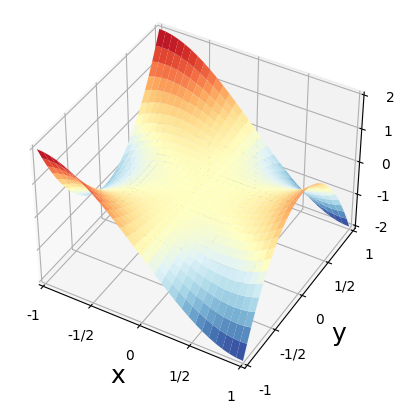

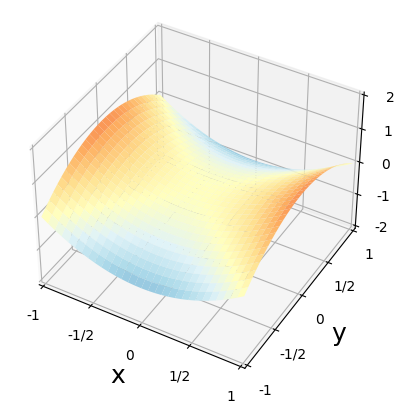

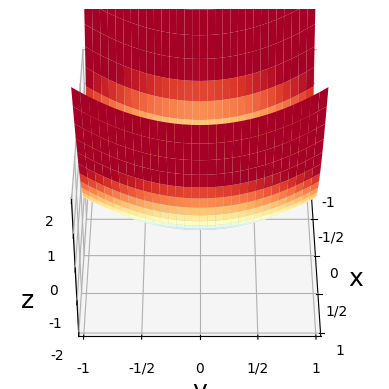

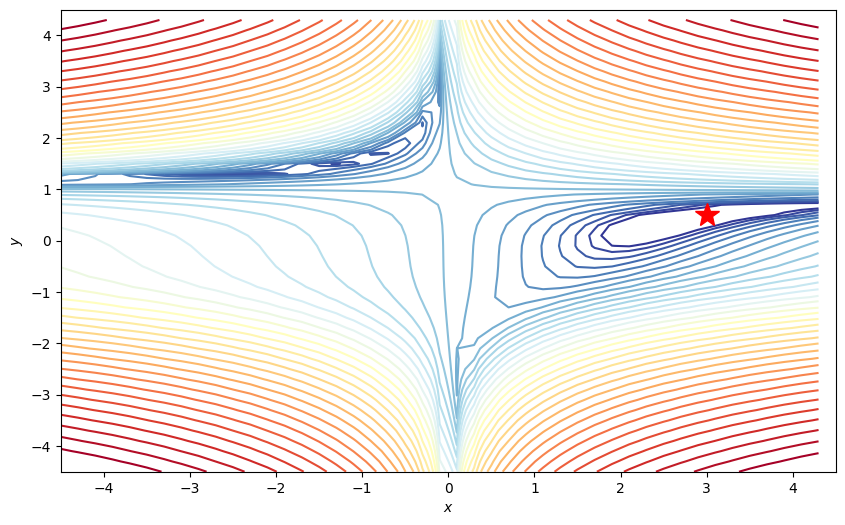

In [95]:
#DEFINE SURFACES WE WILL WORK WITH

#Define monkey saddle and gradient
def monkey_saddle(x,y):
    return x**3 - 3*x*y**2

def grad_monkey_saddle(params):
    x=params[0]
    y=params[1]
    grad_x= 3*x**2-3*y**2
    grad_y= -6*x*y
    return [grad_x,grad_y]

#Define saddle surface

def saddle_surface(x,y,a=1,b=1):
    return a*x**2-b*y**2

def grad_saddle_surface(params,a=1,b=1):
    x=params[0]
    y=params[1]
    grad_x= a*x
    grad_y= -1*b*y
    return [grad_x,grad_y]


# Define minima_surface

def minima_surface(x,y,a=1,b=1):
    return a*x**2+b*y**2-1

def grad_minima_surface(params,a=1,b=1):
    x=params[0]
    y=params[1]
    grad_x= 2*a*x
    grad_y= 2*b*y
    return [grad_x,grad_y]


def beales_function(x,y):
    return np.square(1.5-x+x*y)+np.square(2.25-x+x*y*y)+np.square(2.625-x+x*y**3)
    return f

def grad_beales_function(params,a=1,b=1):
    x=params[0]
    y=params[1]
    grad_x=2*(1.5-x+x*y)*(-1+y)+2*(2.25-x+x*y**2)*(-1+y**2)+2*(2.625-x+x*y**3)*(-1+y**3)
    grad_y=2*(1.5-x+x*y)*x+4*(2.25-x+x*y**2)*x*y+6*(2.625-x+x*y**3)*x*y**2
    return [grad_x,grad_y]

def contour_beales_function():
    #plot beales function
    x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
    fig, ax = plt.subplots(figsize=(10, 6))
    z=beales_function(x,y)
    cax = ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
    ax.plot(3,0.5, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((-4.5, 4.5))
    ax.set_ylim((-4.5, 4.5))
    
    return fig,ax
    
#Make plots of surfaces
plt.close() # closes previous plots
x, y = np.mgrid[-1:1:31j, -1:1:31j]
fig1,ax1=plot_surface(x,y,monkey_saddle(x,y))
fig2,ax2=plot_surface(x,y,saddle_surface(x,y))
fig3,ax3=plot_surface(x,y,minima_surface(x,y,5),0)

#Contour plot of Beale's Function

fig4,ax4 =contour_beales_function()
plt.show()


## Gradient descent with and without momentum

In this notebook, we will visualize various gradient descent algorithms used in machine learning. We will be especially interested in trying to understand how various hyperparameters -- especially the learning rate -- affect our performance. Here, we confine ourselves primarily to looking at the performance in the absence of noise. However, we encourage the reader to experiment with playing with the noise strength below and seeing what differences introducing stochasticity makes. 

Throughout, we denote the parameters by $\theta$ and the energy function we are trying to minimize by $E(\theta)$.

<b>Gradient Descent</b>

We start by considering a simple gradient descent method. In this method,
we will take steps in the direction of the local gradient. Given some parameters $\theta$, we adjust the parameters at each iteration so that

$$\theta_{t+1}= \theta_t - \eta_t \nabla_\theta E(\theta),$$

where we have introduced the learning rate $\eta_t$ that controls how large a step we take. In general, the algorithm is extremely sensitive to the choice of $\eta_t$. If $\eta_t$ is too large, then one can wildly oscillate around minima and miss important structure at small scales. This problem is amplified if our gradient computations are noisy and inexact (as is often the case in machine learning applications). If $\eta_t$ is too small, then the learning/minimization procedure becomes extremely slow. This raises the natural question: <i> What sets the natural scale for the learning rate and how can we adaptively choose it?</i> We discuss this extensively in Section IV of the review.

<b>Gradient Descent with Momentum</b>
One problem with gradient descent is that it has no memory of where the "ball rolling down the hill" comes from. This can be an issue when there are many shallow minima in our landscape. If we make an analogy with a ball rolling down a hill, the lack of memory is equivalent to having no inertia or momentum (i.e. completely overdamped dynamics). Without momentum, the ball has no kinetic energy and cannot climb out of shallow minima. 

Momentum becomes especially important when we start thinking about stochastic gradient descent with noisy, stochastic estimates of the gradient. In this case, we should remember where we were coming from and not react drastically to each new update.



Inspired by this, we can add a memory or momentum term to the stochastic gradient descent term above:

$$
v_{t}=\gamma v_{t-1}+\eta_{t}\nabla_\theta E(\theta_t),\\
\theta_{t+1}= \theta_t -v_{t},
$$

with $0\le \gamma < 1$ called the momentum parameter. When $\gamma=0$, this reduces to ordinary gradient descent, and increasing $\gamma$ increases the inertial contribution to the gradient. From the equations above, we can see that typical memory lifetimes of the gradient is given by $(1-\gamma)^{-1}$. For $\gamma=0$ as in gradient descent, the lifetime is just one step. For $\gamma=0.9$, we typically remember a gradient for ten steps. We will call this gradient descent with classical momentum or CM for short.

A final widely used variant of gradient descent with momentum is called the Nesterov accelerated gradient (NAG). In NAG, rather than calculating the gradient at the current position, one calculates the gradient at the position momentum will carry us to at time $t+1$, namely, $\theta_t -\gamma v_{t-1}$. Thus, the update becomes
$$
v_{t}=\gamma v_{t-1}+\eta_{t}\nabla_\theta E(\theta_t-\gamma v_{t-1})\\
\theta_{t+1}= \theta_t -v_{t}
$$

In [74]:
#This writes a simple gradient descent, gradient descent+ momentum,
#nesterov. 

#Mean-gradient based methods
def gd(grad, init, n_epochs=1000, eta=10**-4, noise_strength=0,a=1,b=1):
    #This is a simple optimizer
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=eta*(np.array(grad(params,a,b))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj


def gd_with_mom(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0,a=1,b=1):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params,a,b))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

def NAG(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0,a=1,b=1):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        params_nesterov=params-gamma*v
        v=gamma*v+eta*(np.array(grad(params_nesterov,a,b))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

## Experiments with GD, CM, and NAG

Before introducing more complicated situations, let us experiment with these methods to gain some intuition.

Let us look at the dependence of GD on learning rate in a simple quadratic minima of the form $z=ax^2+by^2-1$. Make  plots below for $\eta=0.1,0.5,1,1.01$ and $a=1$ and $b=1$. (to do this, you would have to add additional arguments to the function `gd` above in order to pass the new values of `a` and `b`; otherwise the default values `a=1` and `b=1` will be used by the gradient)
<ul>
<li>
What are the qualitatively different behaviors that arise as $\eta$ is increased?
    </ul>
     *As $\eta$ is increased the test points start out further and further away from their final destination and ping pong around much more rapidly while a lower $\eta$ approaches the target incrementally, and the lowest two don't overshoot
    <ul>
<li> What does this tell us about the importance of choosing learning parameters? How do these change if we change $a$ and $b$ above? In particular how does anisotropy change the learning behavior?
    </ul>
      *This is similar to figure 8 in terms of choosing learning parameters, the higher learning rate lead to overshooting and in the most extreme case divercence instead of convergence whearas the lower learning rates lead to more required steps for convergence but a more immediate convergence. Small changes in anisotropy lead to huge changes in the behavior of the learning algorithim, in particular changing a to be 1.1:1 instead of 1 to 1 leads the learning rate of 1 and 1.01 to sample the cost function in areas up to 30 orders of magnitude more than in previous iterations. With algorithims that are not able to sample small enough to move effectivly through the space, small changes are enough for the algorithim to be unsure where the convergences are and be thrown off wildly. This isssue only expands with higher changes to the anisopotry
  <ul>
<li> Make similar plots for CM and NAG? How do the learning rates for these procedures compare with those for GD?
</ul>
     *With CM the faster learning rates are still helpful and lead to convergence even at 1.01 and the anisopotry doesn't lead to ridiculous values until the ratio of a to be is close to 2:1. The added factor of momentum results in a stabler system that is able to converge in a wider variety of situations and with a higher learning rate. NAG has a much harder time dealing with anisopotry with divergence occuring very quickly and very extremely with a small change in anisotropy



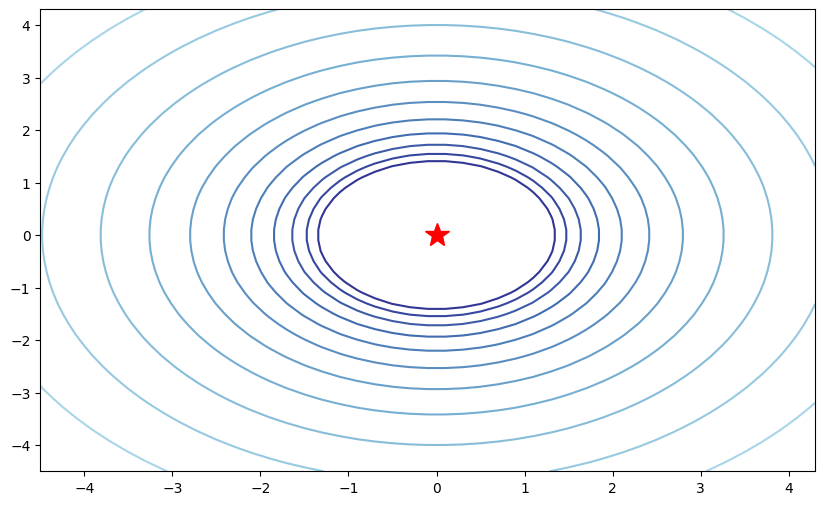

In [64]:
# Investigate effect of learning rate in GD
plt.close()
a,b = 1.1,1
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(minima_surface(x,y,a,b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,4]
init2=[-1.7,4]
init3=[-1.5,4]
init4=[-3,4.5]
eta1=0.1
eta2=0.5
eta3=1
eta4=1.01
a1=a
b1=b
# gd_1=gd(grad_minima_surface,init1, n_epochs=100, eta=eta1,a=a1,b=b1)
# gd_2=gd(grad_minima_surface,init2, n_epochs=100, eta=eta2,a=a1,b=b1)
# gd_3=gd(grad_minima_surface,init3, n_epochs=100, eta=eta3,a=a1,b=b1)
# gd_4=gd(grad_minima_surface,init4, n_epochs=10, eta=eta4,a=a1,b=b1)
# #print(gd_1)
# overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
# overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
# overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
# overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
# plt.legend(loc=2)
# plt.show()
# fig.savefig("GD3regimes.pdf", bbox_inches='tight')


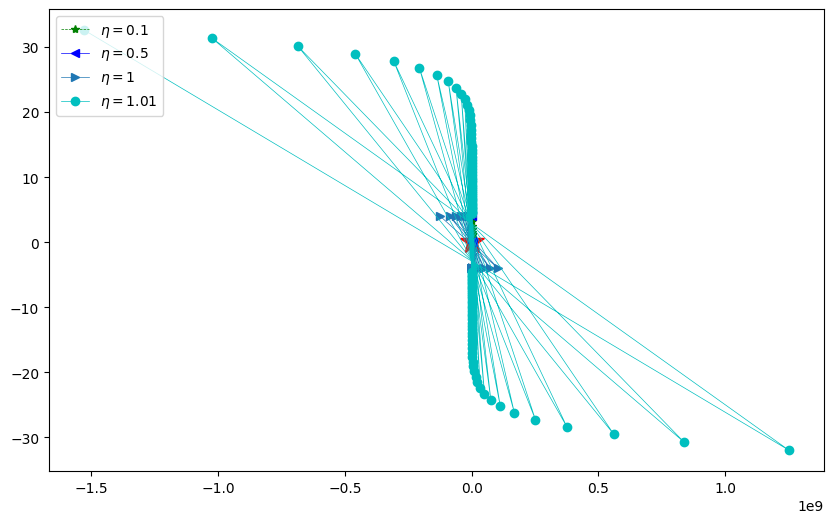

In [89]:
# Investigate effect of learning rate in GD
plt.close()
a,b = 1.1,1
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(minima_surface(x,y,a,b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,4]
init2=[-1.7,4]
init3=[-1.5,4]
init4=[-3,4.5]
eta1=0.1
eta2=0.5
eta3=1
eta4=1.01
a1=a
b1=b
gd_1=gd(grad_minima_surface,init1, n_epochs=100, eta=eta1,a=a1,b=b1)
gd_2=gd(grad_minima_surface,init2, n_epochs=100, eta=eta2,a=a1,b=b1)
gd_3=gd(grad_minima_surface,init3, n_epochs=100, eta=eta3,a=a1,b=b1)
gd_4=gd(grad_minima_surface,init4, n_epochs=100, eta=eta4,a=a1,b=b1)
#print(gd_1)
overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=2)
plt.show()
fig.savefig("GD3regimes.pdf", bbox_inches='tight')

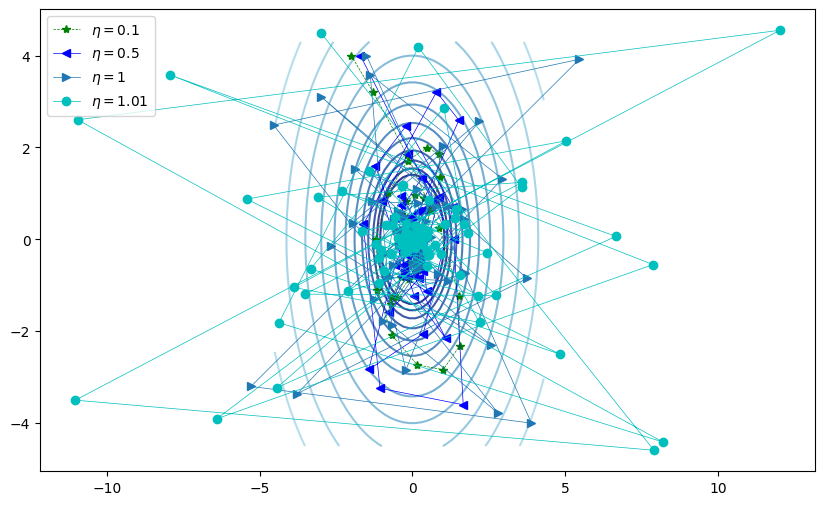

In [80]:
plt.close()
a,b = 1.8,1
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(minima_surface(x,y,a,b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,4]
init2=[-1.7,4]
init3=[-1.5,4]
init4=[-3,4.5]
eta1=0.1
eta2=0.5
eta3=1
eta4=1.01
a1=a
b1=b
gd_1=gd_with_mom(grad_minima_surface,init1, n_epochs=100, eta=eta1,a=a1,b=b1)
gd_2=gd_with_mom(grad_minima_surface,init2, n_epochs=100, eta=eta2,a=a1,b=b1)
gd_3=gd_with_mom(grad_minima_surface,init3, n_epochs=100, eta=eta3,a=a1,b=b1)
gd_4=gd_with_mom(grad_minima_surface,init4, n_epochs=100, eta=eta4,a=a1,b=b1)
#print(gd_1)
overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=2)
plt.show()
fig.savefig("GD3regimes.pdf", bbox_inches='tight')

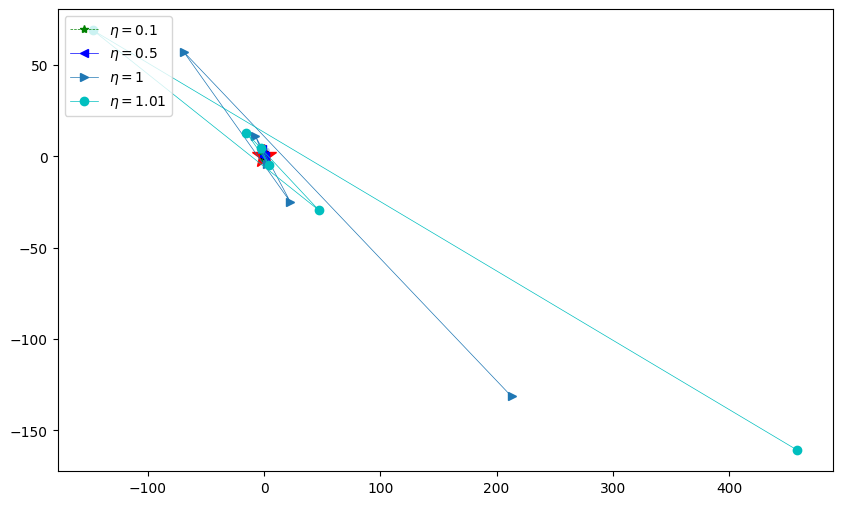

In [92]:
plt.close()
a,b = 1.2,1
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))
z=np.abs(minima_surface(x,y,a,b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,4]
init2=[-1.7,4]
init3=[-1.5,4]
init4=[-3,4.5]
eta1=0.1
eta2=0.5
eta3=1
eta4=1.01
a1=a
b1=b
gd_1=NAG(grad_minima_surface,init1, n_epochs=100, eta=eta1,a=a1,b=b1)
gd_2=NAG(grad_minima_surface,init2, n_epochs=100, eta=eta2,a=a1,b=b1)
gd_3=NAG(grad_minima_surface,init3, n_epochs=5, eta=eta3,a=a1,b=b1)
gd_4=NAG(grad_minima_surface,init4, n_epochs=5, eta=eta4,a=a1,b=b1)
#print(gd_1)
overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=2)
plt.show()
fig.savefig("GD3regimes.pdf", bbox_inches='tight')


## Gradient Descents that utilize the second moment

In stochastic gradient descent, with and without momentum, we still have to specify a  schedule for tuning the learning rates $\eta_t$ as a function of time. As discussed in Sec. IV in the context of Newton's method, this presents a number of dilemmas. The learning rate is limited by the steepest direction which can change depending on where in the landscape we are. To circumvent this problem, ideally our algorithm would take large steps in shallow, flat directions and small steps in steep, narrow directions. Second-order methods accomplish this by calculating or approximating the Hessian and normalizing the learning rate by the curvature. However, this is very computationally expensive for extremely large models.  Ideally, we would like to be able to adaptively change our step size to match the landscape without paying the steep computational price of calculating or approximating Hessians.

Recently, a number of methods have been introduced that accomplish this by tracking not only the gradient but also the second moment of the gradient. These methods include AdaGrad, AdaDelta, RMS-Prop, and ADAM. Here, we discuss the latter of these two as representatives of this class of algorithms.


In RMS prop (Root-Mean-Square propagation), in addition to keeping a running average of the first moment of the gradient, we also keep track of the second moment through a moving average. The update rule for RMS prop is given by
$$
\mathbf{g}_t = \nabla_\theta E(\boldsymbol{\theta}) \\
\mathbf{s}_t =\beta \mathbf{s}_{t-1} +(1-\beta)\mathbf{g}_t^2 \nonumber \\
\boldsymbol{\theta}_{t+1}=\boldsymbol{\theta}_t + \eta_t { \mathbf{g}_t \over \sqrt{\mathbf{s}_t +\epsilon}}, \nonumber \\
$$
where $\beta$ controls the averaging time of the second moment and is typically taken to be about $\beta=0.9$, $\eta_t$ is a learning rate typically chosen to be $10^{-3}$, and $\epsilon\sim 10^{-8}$ is a small regularization constant to prevent divergences. It is clear from this formula that the learning rate is reduced in directions where the norm of the gradient is consistently large. This greatly speeds up the convergence by allowing us to use a larger learning rate for flat directions.

A related algorithm is the ADAM optimizer. In ADAM, we keep a running average of both the first and second moment of the gradient and use this information to adaptively change the learning rate for different parameters. In addition to keeping a running average of the first and second moments of the gradient, ADAM performs an additional bias correction to account for the fact that we are estimating the first two moments of the gradient using a running average (denoted by the hats in the update rule below). The update rule for ADAM is given by (where multiplication and division are understood to be element wise operations)
$$
\mathbf{g}_t = \nabla_\theta E(\boldsymbol{\theta}) \\
\mathbf{m}_t = \beta_1 \mathbf{m}_{t-1} + (1-\beta_1) \mathbf{g}_t \nonumber \\
\mathbf{s}_t =\beta_2 \mathbf{s}_{t-1} +(1-\beta_2)\mathbf{g}_t^2 \nonumber \\
\hat{\mathbf{m}}_t={\mathbf{m}_t \over 1-\beta_1} \nonumber \\
\hat{\mathbf{s}}_t ={\mathbf{s}_t \over1-\beta_2} \nonumber \\
\boldsymbol{\theta}_{t+1}=\boldsymbol{\theta}_t + \eta_t { \hat{\mathbf{m}}_t \over \sqrt{\hat{\mathbf{s}}_t +\epsilon}}, \nonumber 
$$
where $\beta_1$ and $\beta_2$ set the memory lifetime of the first and second moment and are typically take to be $0.9$ and $0.99$ respectively, and $\eta$ and $\epsilon$ are identical
to RMSprop.




In [32]:
################################################################################
# Methods that exploit first and second moments of gradient: RMS-PROP and ADAMS
################################################################################

def rms_prop(grad, init, n_epochs=5000, eta=10**-3, beta=0.9,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init#Import relevant packages
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v=eta*np.divide(g,np.sqrt(grad_sq+epsilon))
        params= params-v
        param_traj[j+1,]=params
    return param_traj
                        
                        
def adams(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj

## Experiments with ADAM and RMSprop

In this section, we will experiment with ADAM and RMSprop. To do so, we will use a function commonly used in optimization protocols:

$$
f(x,y)=(1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2.
$$

This function has a global minimum at $(x,y)=(3,0.5)$. We will use GD, GD with classical momentum, NAG, RMSprop, and ADAM to find minima starting at different initial conditions.

One of the things you should experiment with is the learning rate and the number of steps, $N_{\mathrm{steps}}$ we take. Initially, we have set $N_{\mathrm{steps}}=10^4$ and the learning rate for ADAM/RMSprop to $\eta=10^{-3}$ and the learning rate for the remaining methods to $10^{-6}$.
<ul>
<li> Examine the plot for these default values. What do you see?
    </ul>
    *Only ADAMS is able to get to the actual minima, though RMS gets close, all of them go for the many local minima in the area
    <ul>
<li> Make a plot when the learning rate of all methods is $\eta=10^{-6}$? How does your plot change?
    </ul>
      *The path is much shorter, all explore 3 small parameter spaces and only ADAM ADS and GDM even are in the right parameter space. They get "stuck" close to where the initial conditions are
      <ul>
<li> Now set the learning rate for all algorithms to $\eta=10^{-3}$? What goes wrong? Why?
</ul>
*With the higher learning rate GD,GDM and NAG all fail and explore a much higher parameter space than what is needed and end up diverging. This is because with fewer steps these algorithims don't have the necessary precision to step through the complicated gradient without getting "lost" in the other contours, and don't have a seconod moment to help understand the further complexities of the gradient like ADAM and RMSprop do

C:\Users\mebra\AppData\Local\Temp\ipykernel_30940\2592219256.py:47: RuntimeWarning: overflow encountered in scalar multiply
  grad_x=2*(1.5-x+x*y)*(-1+y)+2*(2.25-x+x*y**2)*(-1+y**2)+2*(2.625-x+x*y**3)*(-1+y**3)
C:\Users\mebra\AppData\Local\Temp\ipykernel_30940\2592219256.py:47: RuntimeWarning: overflow encountered in scalar power
  grad_x=2*(1.5-x+x*y)*(-1+y)+2*(2.25-x+x*y**2)*(-1+y**2)+2*(2.625-x+x*y**3)*(-1+y**3)
C:\Users\mebra\AppData\Local\Temp\ipykernel_30940\2592219256.py:48: RuntimeWarning: overflow encountered in scalar multiply
  grad_y=2*(1.5-x+x*y)*x+4*(2.25-x+x*y**2)*x*y+6*(2.625-x+x*y**3)*x*y**2
C:\Users\mebra\AppData\Local\Temp\ipykernel_30940\2592219256.py:48: RuntimeWarning: overflow encountered in scalar power
  grad_y=2*(1.5-x+x*y)*x+4*(2.25-x+x*y**2)*x*y+6*(2.625-x+x*y**3)*x*y**2
C:\Users\mebra\AppData\Local\Temp\ipykernel_30940\2592219256.py:47: RuntimeWarning: invalid value encountered in scalar add
  grad_x=2*(1.5-x+x*y)*(-1+y)+2*(2.25-x+x*y**2)*(-1+y**2)+2*(2.625

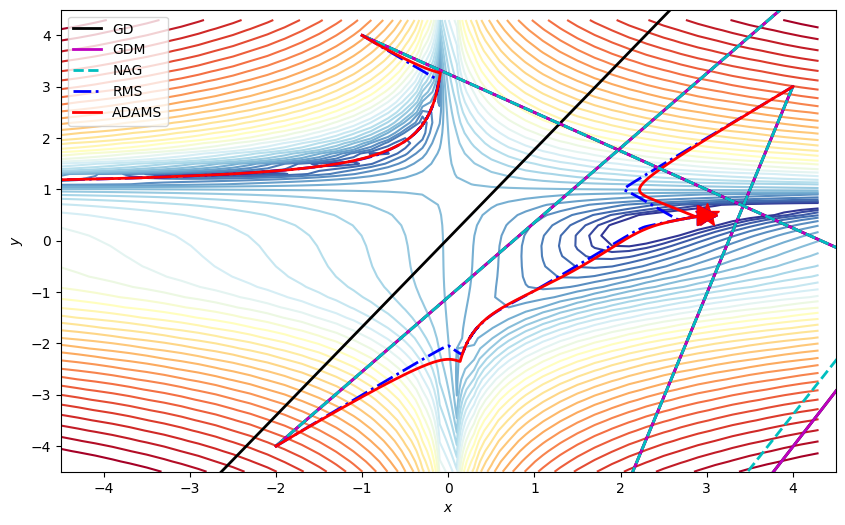

In [101]:
plt.close()
#Make static plot of the results
Nsteps=10**4
lr_l=10**-3
lr_s=10**-3

init1=np.array([4,3])
fig1, ax1=contour_beales_function()

gd_trajectory1=gd(grad_beales_function,init1,Nsteps, eta=lr_s, noise_strength=0)
gdm_trajectory1=gd_with_mom(grad_beales_function,init1,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory1=NAG(grad_beales_function,init1,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory1=rms_prop(grad_beales_function,init1,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory1=adams(grad_beales_function,init1,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gd_trajectory1, 'GD','k')
overlay_trajectory_contour_M(ax1,gd_trajectory1, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory1, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory1,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory1,'ADAMS', 'r')

plt.legend(loc=2)

#init2=np.array([1.5,1.5])
#gd_trajectory2=gd(grad_beales_function,init2,Nsteps, eta=10**-6, noise_strength=0)
#gdm_trajectory2=gd_with_mom(grad_beales_function,init2,Nsteps,eta=10**-6, gamma=0.9,noise_strength=0)
#NAG_trajectory2=NAG(grad_beales_function,init2,Nsteps,eta=10**-6, gamma=0.9,noise_strength=0)
#rms_prop_trajectory2=rms_prop(grad_beales_function,init2,Nsteps,eta=10**-3, beta=0.9,epsilon=10**-8,noise_strength=0)
#adam_trajectory2=adams(grad_beales_function,init2,Nsteps,eta=10**-3, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)
#overlay_trajectory_contour_M(ax1,gdm_trajectory2, 'GDM','m')
#overlay_trajectory_contour_M(ax1,NAG_trajectory2, 'NAG','c--')
#overlay_trajectory_contour_M(ax1,rms_prop_trajectory2,'RMS', 'b-.')
#overlay_trajectory_contour_M(ax1,adam_trajectory2,'ADAMS', 'r')

init3=np.array([-1,4])

gd_trajectory3=gd(grad_beales_function,init3,10**5, eta=lr_s, noise_strength=0,a=1,b=1)
gdm_trajectory3=gd_with_mom(grad_beales_function,init3,10**5,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory3=NAG(grad_beales_function,init3,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory3=rms_prop(grad_beales_function,init3,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory3=adams(grad_beales_function,init3,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gd_trajectory3, 'GD','k')
overlay_trajectory_contour_M(ax1,gdm_trajectory3, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory3, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory3,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory3,'ADAMS', 'r')

init4=np.array([-2,-4])

gd_trajectory4=gd(grad_beales_function,init4,Nsteps, eta=lr_s, noise_strength=0,)
gdm_trajectory4=gd_with_mom(grad_beales_function,init4,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
NAG_trajectory4=NAG(grad_beales_function,init4,Nsteps,eta=lr_s, gamma=0.9,noise_strength=0)
rms_prop_trajectory4=rms_prop(grad_beales_function,init4,Nsteps,eta=lr_l, beta=0.9,epsilon=10**-8,noise_strength=0)
adam_trajectory4=adams(grad_beales_function,init4,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)

overlay_trajectory_contour_M(ax1,gd_trajectory4, 'GD','k')
overlay_trajectory_contour_M(ax1,gdm_trajectory4, 'GDM','m')
overlay_trajectory_contour_M(ax1,NAG_trajectory4, 'NAG','c--')
overlay_trajectory_contour_M(ax1,rms_prop_trajectory4,'RMS', 'b-.')
overlay_trajectory_contour_M(ax1,adam_trajectory4,'ADAMS', 'r')

plt.show()